### 2.1 물체감지

#### 2.1.1 물체 감지 개요
* 바운딩 박스: 물체의 위치를 나타내는 테두리
* 라벨명: 감지된 클래스
* 신뢰도: 얼마나 명확하게 감지했는지

#### 2.1.2 물체 감지 작업의 입력과 출력
* **입력**
     * 이미지
* **출력**
    * 바운딩 박스의 위치와 크기 정보
        * SSD알고리즘: 중심의 좌표(cx, cy), 바운딩박스의 너비(w), 높이(h)로 표현
    * 라벨 정보
        * 감지하려는 물체의 클래스 수(O) + 배경 클래스(1)
    * 신뢰도
        * 각 바운딩 박스와 라벨에 대한 신뢰도

#### 2.1.3 VOC 데이터셋이란
* 클래스: 20종류, 훈련 데이터: 5,717장, 검증데이터: 5,823장
* 각 이미지마다 바운딩 박스의 정답 정보가 있음(어노테이션 정보)
    * xmin, ymin, xmax, ymax, 물체의 클래스를 나타내는 라벨

#### 2.1.4 SSD를 활용한 물체 감지 흐름
* DBox를 준비하고 BBox로 변형
    * Offset 정보: DBox를 변형시키는 정보
    
    
* Step1. 300x300으로 이미지 **resize** + **색 표준화**
* Step2. 디폴트 박스 8,732개 준비
* Step3. SSD 네트워크에 화상 입력
    * 출력: 디폴트박스(8732개) x (각 클래스의 신뢰도: 21개 + 오프셋: 4개)
* Step4. 신뢰도 높은 디폴트 박스 추출
* Step5. 디폴트 박스를 바운딩 박스로 변형
    * Offset 사용
* Step6. 최종 바운딩 박스와 라벨 출력

### 2.2 데이터셋 구현

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


#### 2.2.4 화상데이터, 어노테이션 데이터의 파일 경로 리스트 작성
* 화상 데이터와 어노테이션 데이터의 파일 경로를 리스트형 변수로 생성
* 훈련 및 검증용으로 네 개의 래스트를 작성해야됨
    * (train_img_list, train_anno_list, val_img_list, val_anno_list)
    
    
* **물체 감지**는 화상 데이터와 함께 **어노테이션 데이터를 데이터셋에서 처리**해야됨
* 전처리로 인해 이미지가 변경된다면 어노테이션 정보도 같이 변경해주어야됨

In [3]:
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

#### 난수시드 설정
* 난수 seed를 사용하면 동일한 난수 생성 가능
* **다시 학습하더라도 같은 결과**를 얻을 수 있음

In [4]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [7]:
# 학습 및 검증용 화상데이터, 어노테이션 데이터의 파일 경로 리스트 작성
def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 작성
    
    Parameters
    ----------
    rootpath : str
        데이터 폴더 경로
        
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID(파일 이름) 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [9]:
# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 동작 확인
print(train_img_list[0])

NameError: name 'osp' is not defined

#### 2.2.5 xml 형식의 어노테이션 데이터를 리스트로 변환하기
* `Anno_xml2list`클래스
    * xml 데이터를 파이썬 리스트형 변수로 변환

In [7]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스
class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes: 리스트
        VOC의 클래스명을 저장하느 리스트
    """
    
    def __init__(self, classes):
        self.classes = classes
    def __call__(self, xml_path, width, height):
        """
        한 화상의 XML형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
        
        Parameters
        ----------
        xml_path: str
            xml 파일 경로
        width: int
            대상 화상 폭
        height: int
            대상 화상 높이
        
        Returns
        -------
        
        ret: [[xmin, ymin, xmax, ymax, label_ind], ...]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만 큼의 요소를 가진다.
        """
        
        # 화상 내 모든 물체의 언테이션을 이 리스트에 저장
        ret = []
        
        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()
        
        # 화상 내 물체(object) 수만큼 반복
        for obj in xml.iter('object'):
            
            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []
            
            
            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1으로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1, 1)이므로 1을 빼서 (0, 0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눈다.
                    cur_pixel /= width
                else:  # y 방향의 경우 높이로 나눈다.
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에[xmin, ymin, xmax, ymax, label_ind]를 더한다.
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [8]:
# 동작 확인　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV 사용
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [9]:
# utils 폴더에 있는 data_augumentation.py에서 import。
# 입력 영상의 전처리 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상 크기를 300x300으로 한다.
    학습 시 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상 이미지의 크기
    color_mean : (B, G, R)
        각 색상 채널의 평균값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 화상의 색조 등 임의로 변화
                Expand(color_mean),  # 이미지의 캔버스 확대
                RandomSampleCrop(),  # 이미지 내의 특정 부분 무작위 추출
                RandomMirror(),  # 이미지 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size),  # 이미지 크기를 inputxinput_size로 변형
                SubtractMeans(color_mean)  # BGR색상의 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float로 변환
                Resize(input_size),  # 이미지 크기를 input_size×input_size로 변형
                SubtractMeans(color_mean)  # BGR색상의 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정。
        """
        return self.data_transform[phase](img, boxes, labels)


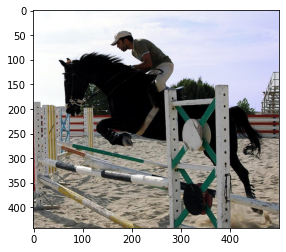

C:\Users\kodhd\pytorch_learning\Chapter2. 물체감지(SSD)\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


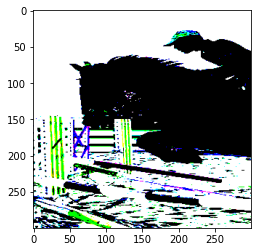

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


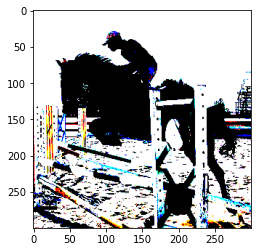

In [10]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 이미지 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR) 색상의 평균값
input_size = 300  # 이미지의 input 사이즈를 300×300으로
transform = DataTransform(input_size, color_mean)

# 5. train이미지 표시
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val이미지 표시
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
            

In [11]:
# VOC2012의 Dataset작성
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train 또는 val 지정
        self.transform = transform  # 이미지 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''화상의 매수 반한'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 이미지의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''
        # 1. 이미지의 매수 반환
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 화상 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 순서 변경
        # (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [12]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 이미지의 input 사이즈를 300x300dmfh gksek.

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력 예
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [13]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
    화상 내의 물체 수가 두 개이면 (2, 5) 사이즈이지만 세 개이면 (3, 5) 등으로 바뀐다.
    변화에 대응하는 DataLoader를 만드는 collate_fn을 작성한다.
    collate_fn은 파이토치 리스트로 mini-batch를 작성하는 함수이다.
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 이미지 img
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt

    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n, 5]
    # n은 이미지마다 다르며 이미지 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets


In [16]:
# 데이터로더 작성

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)  # 첫 번쨰 요소 추출
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # 미니 배치 크기의 리스트, 각 요소는 [n, 5], n은 물체 수 


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [15]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


In [28]:
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [29]:
# 34 층에 걸친 vgg 모듈 작성
def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수

    # vgg 모듈에서 사용하는 합성곱 층이나 최대 풀링 채널 수
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과(float)에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # 디폴트는 계산 결과(float)에서 출력 크기의 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 동작확인
vgg_test = make_vgg()
print(vgg_test)


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [22]:
# 8층에 걸친 extra 모듈 작성
def make_extras():
    layers = []
    in_channels = 1024  # vgg 모듈에서 출력된 extra에 입력되는 이미지 채널 수

    # extra 모듈의 합성곱 층 채널 수를 설정하는 구성
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 활성화 함수의 ReLU는 이번에는 SSD모듈의 순전파에서 준비하고
    # extra모듈에서는 준비하지 않는다.
    return nn.ModuleList(layers)


# 동작확인
extras_test = make_extras()
print(extras_test)


ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [23]:
# 디폴트 박스의 오프셋을 출력하는 loc_layers와
# 디폴트 박스의 각 클래스 신뢰도 confidence를 출력하는 conf_layers 작성
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0] * num_classes, kernel_size=3, padding=1)]

    # VGG 최종층(source2)의 합성곱 층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, kernel_size=3, padding=1)]

    # extra(source3)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2] * num_classes, kernel_size=3, padding=1)]

    # extra(source4)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3] * num_classes, kernel_size=3, padding=1)]

    # extra(source5)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4] * num_classes, kernel_size=3, padding=1)]

    # extra(source6)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5] * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

# 동작확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)


ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [24]:
# convC4_3의 출력을 scale = 20의 L2Norm으로 정규화하는 층
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weight의 초기값으로 설정할 값
        self.reset_parameters()  # 파라미터 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale 크기 값으로 초기화 실행'''
        init.constant_(self.weight, self.scale)  # weightの値がすべてscale（=20）になる

    def forward(self, x):
        '''38×38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다.
        38×38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층'''

        # 각 채널의 38x38개 특징량의 채널 방향 제곱합을 계산하고
        # 루트를 구해 나누어 정규화한다.
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])로
        # torch.Size([batch_num, 512, 38, 38])까지 변형한다.
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

In [25]:
# 디폴트박스를 출력하는 클래스
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기설정
        self.image_size = cfg['input_size']  # 이미지의 크기: 300
        # [38, 19, …] 각 소스의 특징량 맵의 크기
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # 소스의 개수: 6
        self.steps = cfg['steps']  # [8, 16, …] DBox의 픽셀 크기
        
        # [30, 60, ...] 작은 정사각형의 DBox 피셀 크기(정확히는 면적)
        self.min_sizes = cfg['min_sizes']
        
        # [60, 111, ...] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)
        self.max_sizes = cfg['max_sizes']
        
        # 정사각형의 DBox 화면비(종횡비)
        self.aspect_ratios = cfg['aspect_ratios']

    def make_dbox_list(self):
        '''DBox 작성'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f까지의 수로 두 쌍의 조합을 작성. f_P_2개
                # 특징량의 이미지 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x, y. 0~1로 정규화되어 있다.
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 외 화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 화상 밖으로 돌출되는 것을 막기 위해 크기를 최소: 0, 최대: 1로 한다.
        output.clamp_(max=1, min=0)

        return output


In [26]:
# 동작확인

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 화상 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출발할 Box 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX크기를 정한다.
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX크기를 정한다.
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX크기를 정한다.
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBox 출력 확인
pd.DataFrame(dbox_list.numpy())


,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [27]:
# SSD 클래스 작성
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수: 21

        # SSD 네크워크 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBOX 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()


# 동작확인
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256, 

------

In [64]:
# オフセット情報を使い、DBoxをBBoxに変換する関数


def decode(loc, dbox_list):
    """
    オフセット情報を使い、DBoxをBBoxに変換する。

    Parameters
    ----------
    loc:  [8732,4]
        SSDモデルで推論するオフセット情報。
    dbox_list: [8732,4]
        DBoxの情報

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBoxの情報
    """

    # DBoxは[cx, cy, width, height]で格納されている
    # locも[Δcx, Δcy, Δwidth, Δheight]で格納されている

    # オフセット情報からBBoxを求める
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])となります

    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2  # 座標(xmin,ymin)へ変換
    boxes[:, 2:] += boxes[:, :2]  # 座標(xmax,ymax)へ変換

    return boxes


In [65]:
# Non-Maximum Suppressionを行う関数


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。

    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報

    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアの和（OR）の面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去

    # whileのループが抜けたら終了

    return keep, count


In [66]:
# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する


class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # confをソフトマックス関数で正規化するために用意
        self.conf_thresh = conf_thresh  # confがconf_thresh=0.01より高いDBoxのみを扱う
        self.top_k = top_k  # nm_supressionでconfの高いtop_k個を計算に使用する, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressionでIOUがnms_thresh=0.45より大きいと、同一物体へのBBoxとみなす

    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """

        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)

        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confのコピーを作成
            conf_scores = conf_preds[i].clone()

            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):

                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]

                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue

                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす

                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数

                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])


In [67]:
# SSDクラスを作成する


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル




In [68]:
class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードが特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c


In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cpu


In [70]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn


# ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# DataLoaderを作成する
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [71]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


使用デバイス： cpu
ネットワーク設定完了：学習済みの重みをロードしました


In [72]:
import torch.optim as optim
from utils.ssd_model import MultiBoxLoss

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)


In [73]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのloss （Issue158での誤植修正）
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')


In [74]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

In [75]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


FileNotFoundError: [Errno 2] No such file or directory: './weights/ssd300_50.pth'

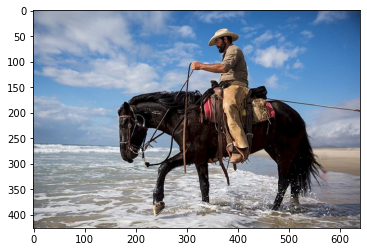

torch.Size([1, 21, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.1113, -0.0303,  0.8972,  0.1153,  1.0460],
          [ 0.1032, -0.0338,  0.5734,  0.1175,  0.7258],
          [ 0.1026,  0.6362,  0.9007,  0.7856,  1.0461],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.1065,  0.9422,  0.4365,  1.0104,  0.5857],
          [ 0.1064,  0.9433,  0.3569,  1.0110,  0.5072],
          [ 0.1022,  0.2514,  0.1976,  0.3164,  0.3539],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [

In [76]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）


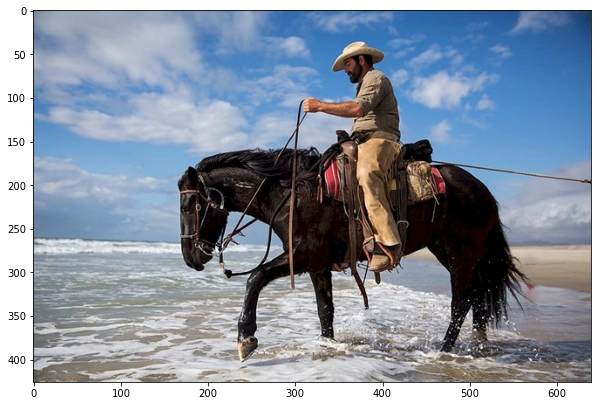

In [77]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/cowboy-757575_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)



In [11]:
import os
import urllib.request
import zipfile
import tarfile

In [12]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [13]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [ ]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ
    

In [10]:
# 学習済みのSSD用のVGGのパラメータをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)